#  Minimum Spanning Tree Problem 
## Multicommodity flow formulation


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt


In [4]:
class args:
    filename = None
    scale = 40
    figsize = (6,6)
    
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

In [5]:
args.filename = "graph.gml"
args.figsize = 10,12

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


In [6]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [7]:
G.nodes(data=True)

NodeDataView({0: {'y': 33, 'x': 1, 'old': 1}, 1: {'y': 16, 'x': 26, 'old': 2}, 2: {'y': 25, 'x': 19, 'old': 3}, 3: {'y': 30, 'x': 27, 'old': 4}, 4: {'y': 17, 'x': 28, 'old': 5}, 5: {'y': 5, 'x': 23, 'old': 6}, 6: {'y': 28, 'x': 23, 'old': 7}, 7: {'y': 25, 'x': 24, 'old': 8}, 8: {'y': 39, 'x': 3, 'old': 9}, 9: {'y': 20, 'x': 11, 'old': 10}})

In [8]:
pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}

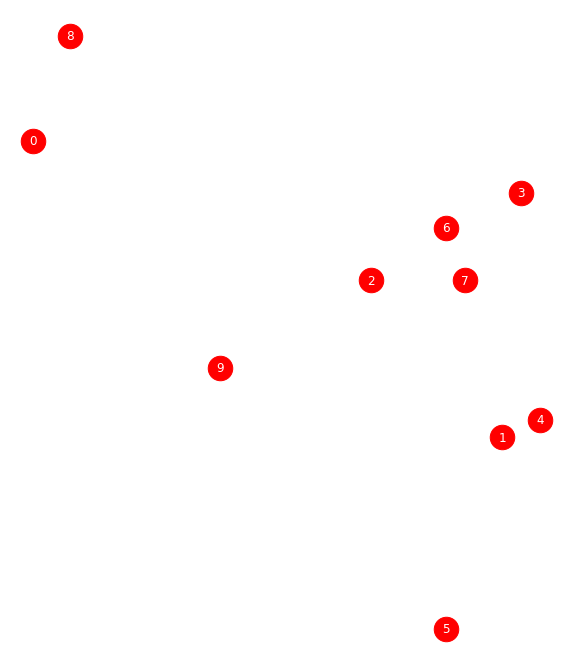

In [9]:
DrawInitG(G)

## Decision variables

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 


$$
y_{ij}= \{\text{capacity for the flow of each commodity $k$ in arc } (i,j)\}
$$

$$
f^k_{ij} = \{\text{flow of commodity $k$ carried by the arc } (i,j)\}
$$


In [10]:
G.nodes()
root = 0

In [11]:
D = G.to_directed()

In [12]:
mstmulti = gb.Model()


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-15
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


In [13]:
x = mstmulti.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')


In [14]:
y = mstmulti.addVars(D.edges(), \
                         ub=1.0, vtype=gb.GRB.BINARY,\
                         name='y')

In [15]:
commodities = list(G.nodes())[1:]
commodities

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
f = mstmulti.addVars(D.edges(), \
                         commodities, \
                         ub=G.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, \
                         name='f')

In [17]:
mstmulti.write('multi.lp')

\begin{alignat}{3}
\min cx &&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \; \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

In [18]:
# ROOT CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmulti.addConstr(f.sum(root, '*', k) - \
                           f.sum('*',root,k) \
                           == 1, name)

mstmulti.update()

In [19]:
mstmulti.write('multi.lp')

In [20]:
# BALANCE CONSTRAINTS: written for all nodes different from root

for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmulti.update()


In [21]:
mstmulti.write('multi.lp')

In [22]:
# TERMINAL CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)

mstmulti.update()


In [23]:
mstmulti.write('multi.lp')

In [24]:
# VARIABLE CAPACITY constraints

for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)

mstmulti.update()


In [25]:
mstmulti.write('multi.lp')

In [26]:
# CARDINALITY constraint

mstmulti.addConstr(y.sum() == G.number_of_nodes() - 1, "Cardinality")

mstmulti.update()

In [27]:
# EQUALITY constraints

for i,j in G.edges():
 
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    
mstmulti.update()

In [28]:
mstmulti.write('multi.lp')

In [29]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 946 rows, 945 columns and 3465 nonzeros
Model fingerprint: 0x23f536ed
Variable types: 810 continuous, 135 integer (135 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 19712.000000
Presolve removed 0 rows and 45 columns
Presolve time: 0.00s
Presolved: 946 rows, 900 columns, 3420 nonzeros
Variable types: 810 continuous, 90 integer (90 binary)

Root relaxation: objective 6.735000e+03, 282 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    6735.0000000 6735.00000  0.00%     -    0s

Explored 0 nodes (282 simplex iterations) in 0.02

Optimal solution: 6735.0


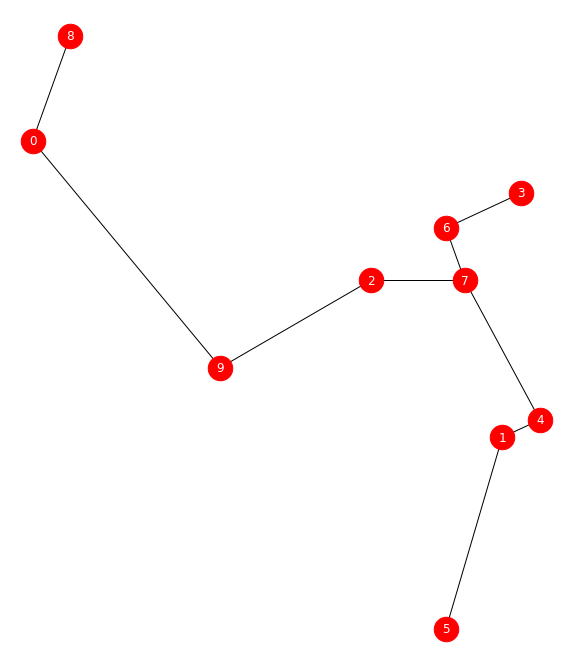

In [30]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)
